In [33]:

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

import re
import os
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import math
%matplotlib inline

In [34]:
#pip install --upgrade tensorflow 

In [35]:
data=pd.read_csv("Tweets.csv")
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [36]:
data.describe()

,tweet_id,airline_sentiment_confidence,negativereason_confidence,retweet_count
count,1.464000e+04,14640.000000,10522.000000,14640.000000
mean,5.692184e+17,0.900169,0.638298,0.082650
std,7.791112e+14,0.162830,0.330440,0.745778
min,5.675883e+17,0.335000,0.000000,0.000000
25%,5.685592e+17,0.692300,0.360600,0.000000
50%,5.694779e+17,1.000000,0.670600,0.000000
75%,5.698905e+17,1.000000,1.000000,0.000000
max,5.703106e+17,1.000000,1.000000,44.000000


In [37]:
data.shape

(14640, 15)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [39]:
data['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

<AxesSubplot:ylabel='airline'>

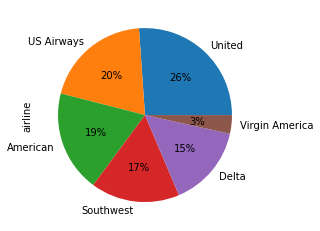

In [40]:
data.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

<AxesSubplot:ylabel='airline_sentiment'>

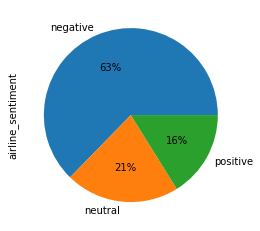

In [41]:
data.airline_sentiment.value_counts().plot(kind='pie', autopct='%1.0f%%')


In [42]:
pd.crosstab(data.airline, data.airline_sentiment)

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


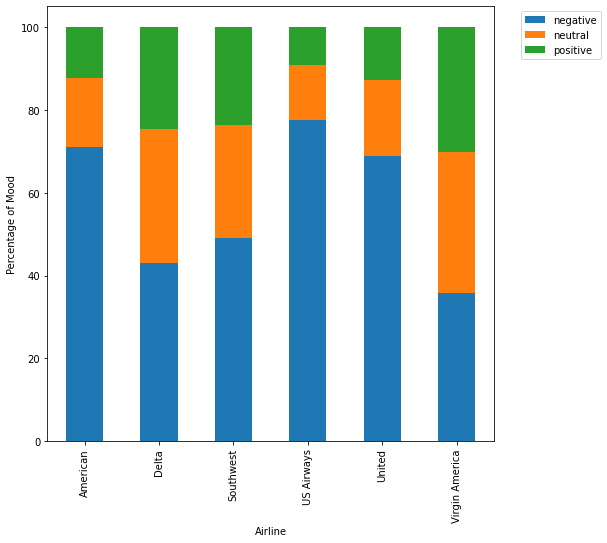

In [43]:
#Visualize sentiment in precentage per airline
x = pd.crosstab(data.airline, data.airline_sentiment).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar',figsize=(8,8),stacked=True)
x.title.set_size(18)
x.set_xlabel('Airline')
x.set_ylabel('Percentage of Mood')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

Text(0, 0.5, 'Negative Reasons')

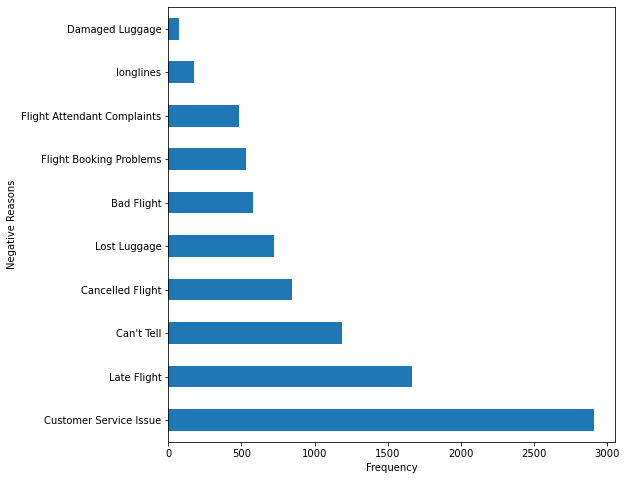

In [44]:
#Visualize how many tweets per negative reasons
colors = sns.color_palette('husl',10)
data.negativereason.value_counts().plot(kind='barh',figsize=(8,8))
plt.xlabel('Frequency')
plt.ylabel('Negative Reasons')

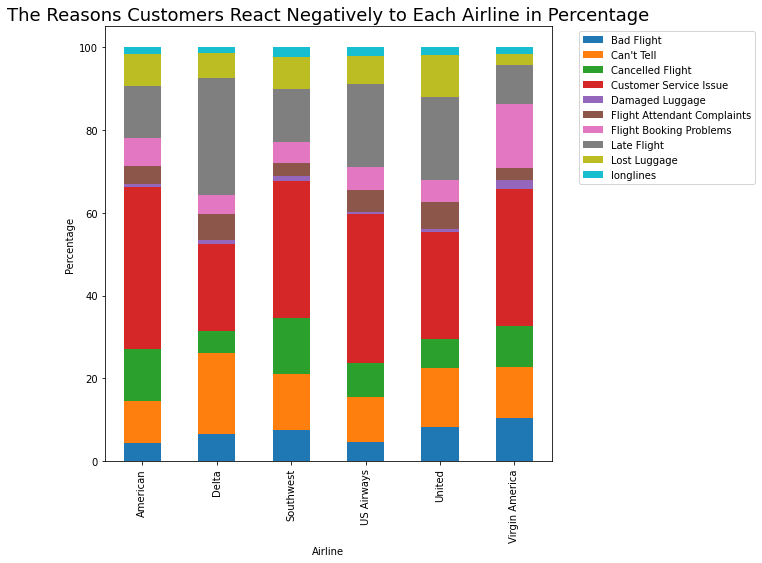

In [45]:

#Visualize negative reasons in precentage per airline
colors=sns.color_palette("husl",10)
pd.crosstab(data.airline, data.negativereason).apply(lambda x: x/x.sum() * 100, axis=1).plot(kind="bar",figsize=(8,8),stacked=True)
plt.title('The Reasons Customers React Negatively to Each Airline in Percentage', fontsize=18)
plt.xlabel('Airline')
plt.ylabel('Percentage')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

<AxesSubplot:ylabel='user_timezone'>

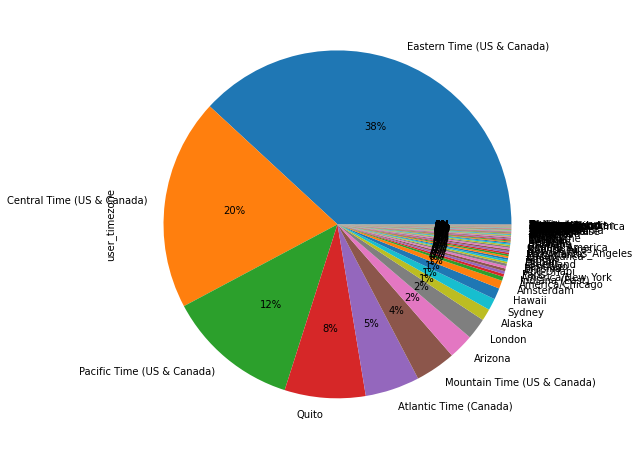

In [46]:
data.user_timezone.value_counts().plot(kind='pie', autopct='%1.0f%%',figsize=(8,8))

# Data Preprocessing

In [47]:
from tensorflow.keras.layers import Embedding

In [48]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence

In [49]:
data['airline_sentiment'] = data['airline_sentiment'].replace('neutral', 1)
data['airline_sentiment'] = data['airline_sentiment'].replace('negative', 0)
data['airline_sentiment'] = data['airline_sentiment'].replace('positive', 2)

In [50]:
X = data['text']
y = data['airline_sentiment']

In [51]:
t = Tokenizer()
t.fit_on_texts(X)

In [52]:
vocab_size = len(t.word_index) + 1

In [53]:
sequences = t.texts_to_sequences(X)

In [54]:
def max_tweet():
    for i in range(1, len(sequences)):
        max_length = len(sequences[0])
        if len(sequences[i]) > max_length:
            max_length = len(sequences[i])
    return max_length

In [55]:
tweet_num = max_tweet()
tweet_num

30

In [56]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
maxlen = tweet_num
padded_X = pad_sequences(sequences, padding='post', maxlen=maxlen)

In [57]:
labels = to_categorical(np.asarray(y))

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_X, labels, test_size = 0.2, random_state = 0)

In [59]:
print('X_train size:', X_train.shape)
print('y_train size:', y_train.shape)
print('X_test size:', X_test.shape)
print('y_test size:', y_test.shape)

X_train size: (11712, 30)
y_train size: (11712, 3)
X_test size: (2928, 30)
y_test size: (2928, 3)


In [72]:
embeddings_index = dict()
f = open('glove.6B.100d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


In [73]:
embedding_matrix = np.zeros((vocab_size, 100))

# fill in matrix
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # add to matrix
        embedding_matrix[i] = embedding_vector

In [74]:
from tensorflow.keras.layers import Embedding

# input is vocab_size, output is 100
# weights from embedding matrix, set trainable = False
embedding_layer = Embedding(input_dim=vocab_size, output_dim=100, weights=[embedding_matrix],
                           input_length = tweet_num, trainable=False)